# Time Series Forecasting

Today you are an MLE in the Personalization Department in Macy's cosmetics!
Your goal is to predict outcomes of online browsing sessions, namely predicting if the next sequence of events/session will result in a purchase or not. 

Models used in this assignment are similar to https://github.com/guillaume-chevalier/seq2seq-signal-prediction/blob/master/seq2seq.ipynb

This work is the modification from the paper: https://arxiv.org/ftp/arxiv/papers/2010/2010.02503.pdf

## Task 0: Setup

1. If you're in Colab, mount your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. Download the `Sequence_Models` folder. It should have two datasets: `shopping.pkl` and `Session_features.pkl`. If you're using Colab, upload them to Google Drive.

## Task 1: Getting familiar with the Data

We'll do some data exploration as well as some data munging to get the data in the form we'll need for the models.

1. Read in the dataset and look at the first few rows.

In [ ]:
import pandas as pd
data = pd.read_pickle('/content/drive/My Drive/FourthBrain/Assignments/Week_10/Sequence_Models/shopping.pkl')
print('Shape of data=', data.shape)
data.head()

Shape of data= (1500000, 12)


,event_time,event_type,product_id,category_id,brand,price,user_id,user_session,year,month,weekday,hour
0,2019-12-01 00:00:00,remove_from_cart,5712790,1487580005268456287,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,2019,12,Sunday,0
1,2019-12-01 00:00:00,view,5764655,1487580005411062629,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18,2019,12,Sunday,0
2,2019-12-01 00:00:02,cart,4958,1487580009471148064,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554,2019,12,Sunday,0
3,2019-12-01 00:00:05,view,5848413,1487580007675986893,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4,2019,12,Sunday,0
4,2019-12-01 00:00:07,view,5824148,1487580005511725929,nan,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5,2019,12,Sunday,0


Each row corresponds to a user event and other stats including the time and product information.

Note that we have 1.5 million rows.

2. What are the unique values for the event column?

In [ ]:
data.event_type.unique()

array(['remove_from_cart', 'view', 'cart', 'purchase'], dtype=object)

There's a lot of data we could use here, but we're going to start with something pretty simple. Think of a user session as being made up of a series of events (e.g. `['view', (add to)'cart', 'view', (add to)'cart', 'purchase']`). We want a model that can take in a series of non-purchase events, and predict whether a purchase is going to occur. In the example above, `['view', (add to)'cart', 'view', (add to)'cart']` is a **sequence** which culminates in a purchase. We'll create a representation of sequences of events, and train a model to predict whether or not a purchase is going to occur.

3. Convert the event types to numeric values.

In [ ]:
events = {'purchase': 1, 'cart': 2, 'view': 3, 'remove_from_cart': 4}
data['event'] = data.event_type.map(events)
data.head()

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session,year,month,weekday,hour,event
0,2019-12-01 00:00:00,remove_from_cart,5712790,1487580005268456287,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,2019,12,Sunday,0,4
1,2019-12-01 00:00:00,view,5764655,1487580005411062629,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18,2019,12,Sunday,0,3
2,2019-12-01 00:00:02,cart,4958,1487580009471148064,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554,2019,12,Sunday,0,2
3,2019-12-01 00:00:05,view,5848413,1487580007675986893,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4,2019,12,Sunday,0,3
4,2019-12-01 00:00:07,view,5824148,1487580005511725929,nan,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5,2019,12,Sunday,0,3


4. Sort the events by `event_time` so we can create the sequences of events in the correct order.

In [ ]:
data.sort_values('event_time', inplace=True)
data.head()

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session,year,month,weekday,hour,event
0,2019-12-01 00:00:00,remove_from_cart,5712790,1487580005268456287,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,2019,12,Sunday,0,4
1,2019-12-01 00:00:00,view,5764655,1487580005411062629,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18,2019,12,Sunday,0,3
2,2019-12-01 00:00:02,cart,4958,1487580009471148064,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554,2019,12,Sunday,0,2
3,2019-12-01 00:00:05,view,5848413,1487580007675986893,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4,2019,12,Sunday,0,3
4,2019-12-01 00:00:07,view,5824148,1487580005511725929,nan,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5,2019,12,Sunday,0,3


5. Group the data by `user_session` so there is one row per user session and a list of all the events for that user sesion.

In [ ]:
sequence = data.groupby('user_session')['event'].apply(list).reset_index()
sequence.head()

,user_session,event
0,00002f36-401d-4bc5-bac6-1a683f52ac2b,[3]
1,00013a97-708c-4e1c-ae3e-e23a5a6d3f9e,[3]
2,00018d32-afba-4db8-9d3d-562c83580579,"[3, 2]"
3,0001ccf7-9af0-45e8-b008-3cefe4f703cb,[3]
4,0001d956-e104-487b-a045-3864d7b9a022,"[2, 2, 2, 2, 2, 2, 2]"


6. Create a `purchase` column, which is 1 if there was a purchase in the user session and 0 otherwise. Recall that the purchase event is denoted by 1.

In [ ]:
sequence['purchase'] = sequence.event.apply(lambda x: 1 if 1 in x else 0)
sequence.head()

,user_session,event,purchase
0,00002f36-401d-4bc5-bac6-1a683f52ac2b,[3],0
1,00013a97-708c-4e1c-ae3e-e23a5a6d3f9e,[3],0
2,00018d32-afba-4db8-9d3d-562c83580579,"[3, 2]",0
3,0001ccf7-9af0-45e8-b008-3cefe4f703cb,[3],0
4,0001d956-e104-487b-a045-3864d7b9a022,"[2, 2, 2, 2, 2, 2, 2]",0


7. Remove purchase events from the lists of events so the event lists contain only view, cart, and remove_from_cart events.

In [ ]:
sequence['event'] = sequence.event.apply(lambda event: list(filter(lambda a: a != 1, event)))
print('Total number of records:', sequence.shape[0])
sequence.head()

Total number of records: 336979


,user_session,event,purchase
0,00002f36-401d-4bc5-bac6-1a683f52ac2b,[3],0
1,00013a97-708c-4e1c-ae3e-e23a5a6d3f9e,[3],0
2,00018d32-afba-4db8-9d3d-562c83580579,"[3, 2]",0
3,0001ccf7-9af0-45e8-b008-3cefe4f703cb,[3],0
4,0001d956-e104-487b-a045-3864d7b9a022,"[2, 2, 2, 2, 2, 2, 2]",0


8. How many user sessions do we have?

In [ ]:
print('Total number of records:', sequence.shape[0])

Total number of records: 336979


9. What percent of user sessions lead to a purchase?

In [ ]:
purchase_percent = sequence.purchase.sum() / sequence.shape[0]
print(f'Percent of sessions ending in a purchase: {purchase_percent * 100:.2f}%')

Percent of sessions ending in a purchase: 3.36%


10. What is the distribution of lengths of the sequences?

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


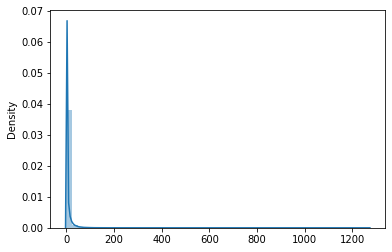

In [ ]:
import seaborn as sns

lengths = sequence['event'].map(len).values
sns.distplot(lengths)

We see that most sequences are about 100 or shorter. 

One difficult task in time series modeling is to find the optimal sequence size for highest prediction accuracy. We won't attemp that today. We'll focus on sequences that have lengths less than or equal to 10.

11. Select all the sequences that are up to 10 events long.

In [ ]:
short_sequence_10 = sequence[sequence['event'].map(len) <= 10]

12. How many user sessions do we have now?

In [ ]:
print('Total number of records:', short_sequence_10.shape[0])

Total number of records: 309214


13. To make the data amenable to training a TensorFlow neural network, we need to make all the sequences the same length. We can use teh `pad_sequences()` function.

In [ ]:
from keras.preprocessing.sequence import pad_sequences

event_sequence = short_sequence_10['event'].values
event = pad_sequences(event_sequence)
print(event[0:5])

[[0 0 0 0 0 0 0 0 0 3]
 [0 0 0 0 0 0 0 0 0 3]
 [0 0 0 0 0 0 0 0 3 2]
 [0 0 0 0 0 0 0 0 0 3]
 [0 0 0 2 2 2 2 2 2 2]]


14. What percent of these sequences lead to a purchase?

In [ ]:
purchase_percent_10 = short_sequence_10.purchase.sum() / short_sequence_10.shape[0]
print(f'Percent of sessions ending in a purchase: {purchase_percent_10 * 100:.2f}%')

Percent of sessions ending in a purchase: 1.96%


## Task 2: Helper Functions for Evaluation

1. Define the `prepare_train_test_data()`, which uses scikit-learn's `train_test_split()` function and resizes the results as needed for the Tensorflow sequence models.

In [ ]:
from sklearn.model_selection import train_test_split

def prepare_train_test_data(data, y):
    X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    return X_train, X_test, y_train, y_test

2. Define `plot_history()` which plots the model fit process.

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    '''
    Plot the model fit process.
    '''
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

3. Define `evaluate_on_test()` which evaluates the fit model on test data.

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_on_test(X_test, y_test, training_model):
    '''
    Evaluate the fit model on test data.
    '''
    model_output=training_model.predict(X_test)
    g_preds = np.argmax(model_output,axis=1)
    gaccuracy = accuracy_score(y_test[:,1], g_preds)
    print('Accuracy: %f' % gaccuracy)
    # precision tp / (tp + fp)
    gprecision = precision_score(y_test[:,1], g_preds)
    print('Precision: %f' % gprecision)
    # recall: tp / (tp + fn)
    grecall = recall_score(y_test[:,1], g_preds)
    print('Recall: %f' % grecall)
    # f1: 2 tp / (2 tp + fp + fn)
    gf1 = f1_score(y_test[:,1], g_preds)
    print('F1 score: %f' % gf1)

## Task 3: Train a RNN model

1. Use the `pd.get_dummies()` function to create the target array `y`.

In [ ]:
y = pd.get_dummies(short_sequence_10['purchase']).values

2. Use the `prepare_train_test_data()` function to get the training and test sets.

In [ ]:
X_train, X_test, y_train, y_test = prepare_train_test_data(event, y)
print("Training data shape:", X_train.shape, y_train.shape)
print("Test data shape:", X_test.shape, y_test.shape)

Training data shape: (216449, 10, 1) (216449, 2)
Test data shape: (92765, 10, 1) (92765, 2)


3. We'll start with training a [`SimpleRNN`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN).

In [ ]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam

def simple_RNN_model(neurons=40, op=10):
    model = Sequential()
    model.add(SimpleRNN(neurons, return_sequences=True, input_shape=(op, 1)))
    model.add(SimpleRNN(2 * neurons))
    model.add(Dense(2, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=0.0003),
        loss='binary_crossentropy',
        metrics=['acc'])
    return model

4. Visualize the model. We'll clear the session each time to make sure we start with a blank slate.

In [ ]:
from tensorflow.keras.backend import clear_session

clear_session()
RNN_model = simple_RNN_model(neurons=40, op=10)
RNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10, 40)            1680      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 80)                9680      
                                                                 
 dense (Dense)               (None, 2)                 162       
                                                                 
Total params: 11,522
Trainable params: 11,522
Non-trainable params: 0
_________________________________________________________________


5. Fit the model using 80/20 validation split at runtime.

In [ ]:
r_history = RNN_model.fit(X_train, y_train, epochs=20, batch_size=1000, validation_split=0.2)

Epoch 1/20
174/174 [==============================] - 5s 23ms/step - loss: 0.1541 - acc: 0.9497 - val_loss: 0.0857 - val_acc: 0.9795
Epoch 2/20
174/174 [==============================] - 4s 22ms/step - loss: 0.0814 - acc: 0.9803 - val_loss: 0.0812 - val_acc: 0.9795
Epoch 3/20
174/174 [==============================] - 4s 22ms/step - loss: 0.0778 - acc: 0.9803 - val_loss: 0.0779 - val_acc: 0.9795
Epoch 4/20
174/174 [==============================] - 4s 21ms/step - loss: 0.0743 - acc: 0.9803 - val_loss: 0.0744 - val_acc: 0.9795
Epoch 5/20
174/174 [==============================] - 4s 22ms/step - loss: 0.0710 - acc: 0.9803 - val_loss: 0.0715 - val_acc: 0.9795
Epoch 6/20
174/174 [==============================] - 4s 22ms/step - loss: 0.0684 - acc: 0.9816 - val_loss: 0.0695 - val_acc: 0.9829
Epoch 7/20
174/174 [==============================] - 4s 21ms/step - loss: 0.0669 - acc: 0.9838 - val_loss: 0.0684 - val_acc: 0.9829
Epoch 8/20
174/174 [==============================] - 3s 20ms/step - 

6. Call the `plot_history()` and `evaluate_on_test()` functions to see the performance.

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


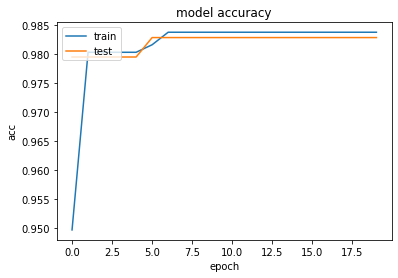

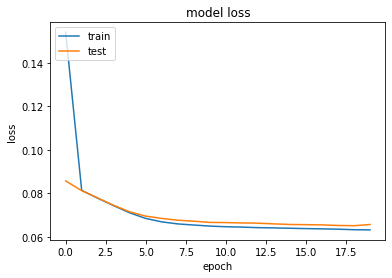

Accuracy: 0.984531
Precision: 1.000000
Recall: 0.185585
F1 score: 0.313068


In [ ]:
plot_history(r_history)
evaluate_on_test(X_test, y_test, RNN_model)

The recall here is fairly low, ostensibly because of the imbalance of purchase and non-purchase events, but this was a good first start.

## Task 4: Train GRU-based and LSTM-based models

1. Define a network based on GRU layers called `GRU_model`. It's the same as the `simple_RNN_model`, except you need to replace the `SimpleRNN` layers for `GRU` layers .

In [ ]:
from keras.layers import GRU

def GRU_model(neurons=40, op=10):
    model = Sequential()
    model.add(GRU(neurons, return_sequences=True, input_shape=(op, 1)))
    model.add(GRU(2 * neurons))
    model.add(Dense(2, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=0.0003),
        loss='binary_crossentropy',
        metrics=['acc'])
    return model

2. Visualize the model.

In [ ]:
clear_session()
G_model = GRU_model()
G_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10, 40)            5160      
                                                                 
 gru_1 (GRU)                 (None, 80)                29280     
                                                                 
 dense (Dense)               (None, 2)                 162       
                                                                 
Total params: 34,602
Trainable params: 34,602
Non-trainable params: 0
_________________________________________________________________


3. Train `G_model` with 40 epocs, 1000 samples per batch, and a validation split of 0.2.

In [ ]:
g_history = G_model.fit(X_train, y_train, 
                        epochs=40, 
                        batch_size=1000, 
                        validation_split=0.2)

Epoch 1/40
174/174 [==============================] - 4s 10ms/step - loss: 0.2257 - acc: 0.9803 - val_loss: 0.1049 - val_acc: 0.9795
Epoch 2/40
174/174 [==============================] - 1s 6ms/step - loss: 0.0955 - acc: 0.9803 - val_loss: 0.0930 - val_acc: 0.9795
Epoch 3/40
174/174 [==============================] - 1s 6ms/step - loss: 0.0859 - acc: 0.9803 - val_loss: 0.0858 - val_acc: 0.9795
Epoch 4/40
174/174 [==============================] - 1s 7ms/step - loss: 0.0831 - acc: 0.9803 - val_loss: 0.0841 - val_acc: 0.9795
Epoch 5/40
174/174 [==============================] - 1s 7ms/step - loss: 0.0810 - acc: 0.9803 - val_loss: 0.0815 - val_acc: 0.9795
Epoch 6/40
174/174 [==============================] - 1s 6ms/step - loss: 0.0771 - acc: 0.9803 - val_loss: 0.0765 - val_acc: 0.9795
Epoch 7/40
174/174 [==============================] - 1s 7ms/step - loss: 0.0715 - acc: 0.9804 - val_loss: 0.0707 - val_acc: 0.9795
Epoch 8/40
174/174 [==============================] - 1s 6ms/step - loss: 0

4. Use the `plot_history()` and `evaluate_on_test()` functions to view the performance of the model. How does it compare to the previous model?

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


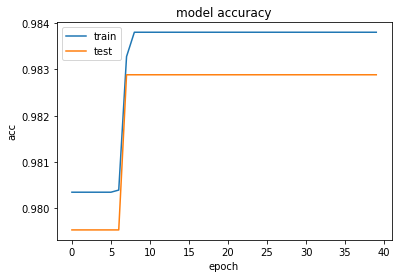

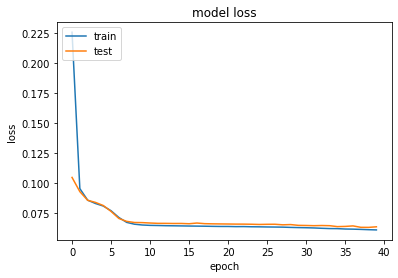

Accuracy: 0.984531
Precision: 1.000000
Recall: 0.185585
F1 score: 0.313068


In [ ]:
plot_history(g_history)
evaluate_on_test(X_test, y_test, G_model)

These may get a very similar performance as the simple RNN, but you can check that it does produce slightly different outputs. GRU recurrent neural networks are just a more complicated type of network and often perform better on sequence prediction tasks. 

5. Now define a LSTM model. It's the same as the `simple_RNN_model` with the `SimpleRNN` layers replaced with [`LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layers. Additionally, try wrapping the first LSTM layer with [`Bidirectional`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional).

In [ ]:
from keras.layers import Bidirectional, LSTM

def LSTM_model(neurons=40, op=10):
    model = Sequential()
    model.add(Bidirectional(LSTM(neurons, return_sequences=True), input_shape=(op, 1)))
    model.add(Bidirectional(LSTM(2 * neurons)))
    model.add(Dense(2, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=0.0003),
        loss='binary_crossentropy',
        metrics=['acc'])
    return model

6. Visualize the model.

In [ ]:
clear_session()
l_model = LSTM_model(neurons=40, op=10)
l_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 10, 80)           13440     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 160)              103040    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 2)                 322       
                                                                 
Total params: 116,802
Trainable params: 116,802
Non-trainable params: 0
_________________________________________________________________


7. Train `l_model` with 20 epochs, 1000 samples per batch, and a validation split of 0.2.

    Note that LSTM can often take longer to fit because it has more free parameters.

In [ ]:
l_history = l_model.fit(X_train, y_train, 
                        epochs=20, 
                        batch_size=1000, 
                        validation_split=0.2)

Epoch 1/20
174/174 [==============================] - 8s 19ms/step - loss: 0.1800 - acc: 0.9803 - val_loss: 0.0787 - val_acc: 0.9795
Epoch 2/20
174/174 [==============================] - 2s 11ms/step - loss: 0.0726 - acc: 0.9803 - val_loss: 0.0725 - val_acc: 0.9795
Epoch 3/20
174/174 [==============================] - 2s 11ms/step - loss: 0.0685 - acc: 0.9819 - val_loss: 0.0697 - val_acc: 0.9829
Epoch 4/20
174/174 [==============================] - 2s 12ms/step - loss: 0.0665 - acc: 0.9838 - val_loss: 0.0689 - val_acc: 0.9829
Epoch 5/20
174/174 [==============================] - 2s 11ms/step - loss: 0.0658 - acc: 0.9838 - val_loss: 0.0681 - val_acc: 0.9829
Epoch 6/20
174/174 [==============================] - 2s 11ms/step - loss: 0.0653 - acc: 0.9838 - val_loss: 0.0676 - val_acc: 0.9829
Epoch 7/20
174/174 [==============================] - 2s 11ms/step - loss: 0.0648 - acc: 0.9838 - val_loss: 0.0671 - val_acc: 0.9829
Epoch 8/20
174/174 [==============================] - 2s 11ms/step - 

8. Use the `plot_history()` and `evaluate_on_test()` functions to view the performance of the model. How does it compare to the previous models?

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


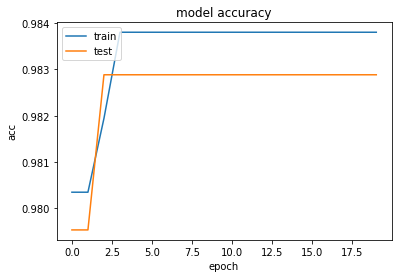

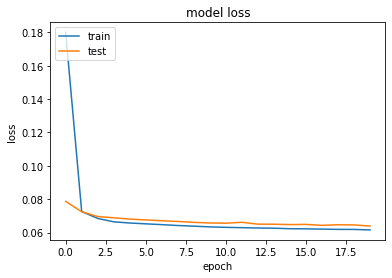

Accuracy: 0.984531
Precision: 1.000000
Recall: 0.185585
F1 score: 0.313068


In [ ]:
plot_history(l_history)
evaluate_on_test(X_test, y_test, l_model)

## Task 5: GRU model on a different dataset

Let's try the GRU model on a different dataset which has more informative features

1. Load the dataset.

In [ ]:
feat = pd.read_pickle('/content/drive/My Drive/FourthBrain/Assignments/Week_10/Sequence_Models/Session_features.pkl')
print('Shape of data:', feat.shape)
feat.head()

Shape of data: (1500000, 36)


,TotalEventsInSession,interactionTime,#TimesCartedinSession,#TimesViewedinSession,maxPrice,minPrice,AvgAmtCartedInSession,AvgAmtViewedInSession,#BrandsCartedInSession,#BrandsViewedInSession,...,Sep,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Noon,Weekend,Purchase
0,7,493.0,0,7,1349.46,131.53,0.00,812.941429,0,7,...,0,0,1,0,0,0,0,0,0,0
1,18,585.0,1,16,1747.79,152.58,289.52,621.671250,1,16,...,0,0,0,1,0,0,0,0,0,1
2,1,0.0,0,1,1422.10,1422.10,0.00,1422.100000,0,1,...,0,0,1,0,0,0,0,0,0,0
3,1,0.0,0,1,308.63,308.63,0.00,308.630000,0,1,...,0,0,0,1,0,0,0,0,0,0
4,11,509.0,4,6,171.90,131.51,171.90,158.220000,4,6,...,0,0,1,0,0,0,0,0,0,1


This is just a different dataset that's focused on whole sessions, for which we have more different types of features (36 of them)

2. Suppose we were to treat each row of features as a "sequence." This is not the most common setup for RNNs, (since each element in the sequence (each column) represents different types of quantities) but it'll work in our case. We'll take the first 35 columns as the elements of our sequence and the 36th column, the purchase column, as the target.

In [ ]:
Xf = feat.iloc[:, 0: 35].values
Yf = feat.iloc[:, 35].values
yf = pd.get_dummies(Yf, prefix='Purchase').values
Xf_train, Xf_test, yf_train, yf_test = prepare_train_test_data(Xf, yf)
print(Xf_train.shape, yf_train.shape)

(1050000, 35, 1) (1050000, 2)


3. Visualize the model (feel free to try a different model than GRU).

In [ ]:
clear_session()
gru_model = GRU_model(neurons=40, op=Xf_train.shape[1])
gru_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 35, 40)            5160      
                                                                 
 gru_1 (GRU)                 (None, 80)                29280     
                                                                 
 dense (Dense)               (None, 2)                 162       
                                                                 
Total params: 34,602
Trainable params: 34,602
Non-trainable params: 0
_________________________________________________________________


4. Fit the model on the training data with 20 epochs, 1000 samples per batch, and a validation split of 0.2.

In [ ]:
gru_history = gru_model.fit(Xf_train, yf_train, epochs=20, batch_size=1000, validation_split=0.2)

Epoch 1/20
840/840 [==============================] - 12s 12ms/step - loss: 0.2225 - acc: 0.9341 - val_loss: 0.0905 - val_acc: 0.9709
Epoch 2/20
840/840 [==============================] - 9s 11ms/step - loss: 0.1475 - acc: 0.9611 - val_loss: 0.2400 - val_acc: 0.9312
Epoch 3/20
840/840 [==============================] - 9s 11ms/step - loss: 0.2306 - acc: 0.9303 - val_loss: 0.2078 - val_acc: 0.9312
Epoch 4/20
840/840 [==============================] - 9s 11ms/step - loss: 0.1432 - acc: 0.9432 - val_loss: 0.0557 - val_acc: 0.9836
Epoch 5/20
840/840 [==============================] - 10s 11ms/step - loss: 0.1523 - acc: 0.9572 - val_loss: 0.2247 - val_acc: 0.9312
Epoch 6/20
840/840 [==============================] - 9s 11ms/step - loss: 0.1879 - acc: 0.9358 - val_loss: 0.0630 - val_acc: 0.9786
Epoch 7/20
840/840 [==============================] - 9s 11ms/step - loss: 0.1618 - acc: 0.9524 - val_loss: 0.2184 - val_acc: 0.9312
Epoch 8/20
840/840 [==============================] - 9s 11ms/step 

5. Use the `plot_history()` and `evaluate_on_test()` functions to view the performance of the model.

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


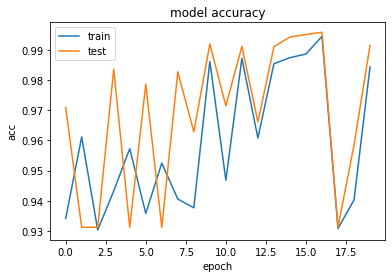

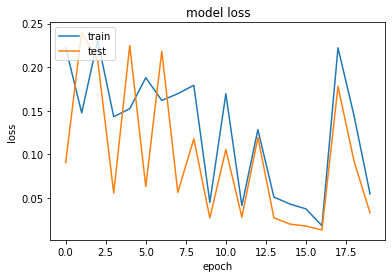

Accuracy: 0.991284
Precision: 0.928916
Recall: 0.946353
F1 score: 0.937554


In [ ]:
plot_history(gru_history)
evaluate_on_test(Xf_test, yf_test, gru_model)

6. Comment on what you would suggest to your manager?

    * Is feature-level data necessary? What metrics suggest that?
    * What you you suggest to improve the quality of the model trained on event-sequence data (the first dataset?) 

I would suggest to add regularization to the model, such as dropout layers, for example. I would also consider addressing label imbalance, as only a small percentage of the dataset actually purchased products.
